# Tutorial 3: Arbitrary Hamiltonian input

In this tutorial, we apply Entanglement Forged VQE to compute the energy of a $H_2$ molecule, but rather than define the problem in terms of a Molecule object, we will input the Hamiltonian directly. 

**What's new here?**
- Defining the chemical problem by input the Hamiltonian directly. 

For comparison, you may wish to review how the same problem was defined using the Molecule object in Tutorial 1. 

### Importing the relevant modules

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from qiskit.circuit.library import TwoLocal
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

import sys

sys.path.append("../../")
from entanglement_forging import (
    EntanglementForgedConfig,
    EntanglementForgedDriver,
    EntanglementForgedGroundStateSolver,
)

## Setting up the problem (the chemistry)

We start by setting up the chemical problem. Here, we specify the properties of the system directly.

In [3]:
# Coefficients that define the one-body terms of the Hamiltonain

hcore = np.array([[-1.12421758, -0.9652574], [-0.9652574, -1.12421758]])

# Coefficients that define the two-body terms of the Hamiltonian
mo_coeff = np.array([[0.54830202, 1.21832731], [0.54830202, -1.21832731]])

# Coefficients for the molecular orbitals

eri = np.array(
    [
        [
            [[0.77460594, 0.44744572], [0.44744572, 0.57187698]],
            [[0.44744572, 0.3009177], [0.3009177, 0.44744572]],
        ],
        [
            [[0.44744572, 0.3009177], [0.3009177, 0.44744572]],
            [[0.57187698, 0.44744572], [0.44744572, 0.77460594]],
        ],
    ]
)

driver = EntanglementForgedDriver(
    hcore=hcore,
    mo_coeff=mo_coeff,
    eri=eri,
    num_alpha=1,
    num_beta=1,
    nuclear_repulsion_energy=0.7199689944489797,
)
problem = ElectronicStructureProblem(driver)
problem.second_q_ops()

converter = QubitConverter(JordanWignerMapper())

_**Note**: after this point, everything is the same as in Tutorial 1._

## Preparing the bitstrings and the ansatz

The ansatz for Forged VQE consists of a set of input bitstrings and a parameterized circuit. In the current implementation, the bitstrings and parameterized circuit are the same for the alpha particle subspace and the beta particle subspace. For a discussion on picking the bitstrings and designing the ansatz, refer to the Explanatory Material. 

In [4]:
bitstrings = [[1, 0], [0, 1]]

ansatz = TwoLocal(2, [], "cry", [[0, 1], [1, 0]], reps=1)

ansatz.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  TwoLocal(θ[0],θ[1]) │
q_1: ┤1                     ├
     └──────────────────────┘

## Running the Forged VQE algorithm

### Statevector simulator

We first create an object that contains all the configuration settings, such as the backend, as well as other execution settings.

In [5]:
from qiskit import Aer

backend = Aer.get_backend("statevector_simulator")

config = EntanglementForgedConfig(
    backend=backend, maxiter=200, initial_params=[0, 0.5 * np.pi]
)

We are now ready to run the calculation and print the results.

In [6]:
calc = EntanglementForgedGroundStateSolver(converter, ansatz, bitstrings, config)
res = calc.solve(problem)

res

Ground state energy (Hartree): -1.1372960821731657
Schmidt values: [-0.99376317  0.11151129]
Optimizer parameters: [  6.28338313 -12.53378645]

We can also extract the results at each iteration of the classical optimizer.  

Energies (from only one paramset in each iteration):


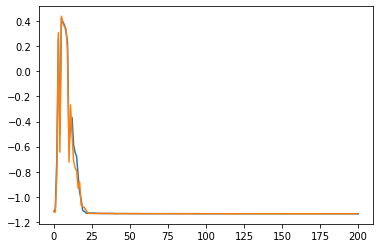

Schmidts (from only one paramset in each iteration):


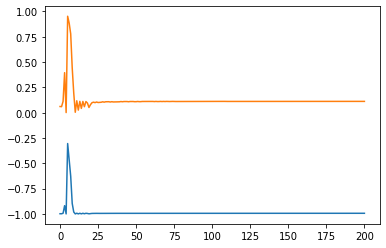

Parameters (from only one paramset in each iteration):


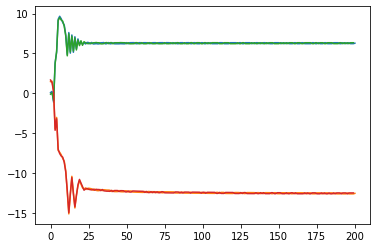

In [7]:
print("Energies (from only one paramset in each iteration):")
plt.plot([e[0] for e in res.get_energies_history()])
plt.plot([e[1] for e in res.get_energies_history()[0:-1]])
plt.show()
print("Schmidts (from only one paramset in each iteration):")
plt.plot([s[0] for s in res.get_schmidts_history()])
plt.show()
print("Parameters (from only one paramset in each iteration):")
plt.plot([p[0] for p in res.get_parameters_history()])
plt.plot([p[1] for p in res.get_parameters_history()[0:-1]])
plt.show()

In [8]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright